## I have chosen a Ridge model, with alpha = 10, on the data that does not include production company.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as rmse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
df = pd.read_pickle('Ordinal_MPAA_merged_with_dummy_genres.pkl')

### Check out the relationship between number of seasons and season 1 rating

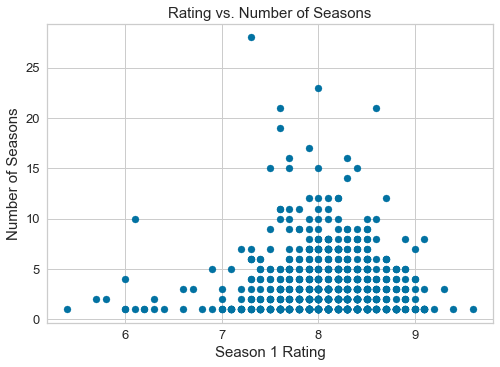

In [203]:
fig, ax = plt.subplots()
ax.scatter(df['Season_1_Rating'], df['Num_of_Seasons'])
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)
ax.set_xlabel('Season 1 Rating', fontsize = 15)
ax.set_ylabel('Number of Seasons', fontsize = 15)
ax.set_title('Rating vs. Number of Seasons', fontsize = 15)
plt.savefig('season1ratingVSseasons.png');

In [54]:
df.sort_values(by = 'Num_of_Seasons', ascending = False).head(20)

,Title,Start_Year,End_Year,Genres,Num_of_Seasons,Num_of_Episodes,Num_Episodes_Per_Season,Season_1_Rating,Years_Ran,Action,...,Other,Romance,Sci-fi,Sport,Thriller,War,MPAA_Rating,Runtime,Series_Type,Ordinal_MPAA
901,Top Gear,2002,0,"[Comedy, Adventure, Other, Other]",28,216,7.71,7.3,18,0,...,1,0,0,0,0,0,TV-PG,1h,TV Series (2002– ),4
116,South Park,1997,0,"[Animation, Comedy]",23,307,13.35,8.0,23,0,...,0,0,0,0,0,0,TV-MA,22min,TV Series (1997– ),6
351,Law & Order: Special Victims Unit,1999,0,"[Drama, Crime, Mystery]",21,478,22.76,8.6,21,0,...,0,0,0,0,0,0,TV-14,1h,TV Series (1999– ),5
555,Midsomer Murders,1997,0,"[Drama, Crime, Mystery]",21,126,6.00,7.6,23,0,...,0,0,0,0,0,0,TV-14,1h 30min,TV Series (1997– ),5
271,Family Guy,1999,0,"[Animation, Comedy]",19,350,18.42,7.6,21,0,...,0,0,0,0,0,0,TV-MA,55min,TV Series (1999–2007),6
486,NCIS,2003,0,"[Action, Drama, Crime]",17,398,23.41,7.9,17,1,...,0,0,0,0,0,0,TV-14,1h,TV Series (2003– ),5
278,Grey's Anatomy,2005,0,"[Romance, Drama]",16,363,22.69,8.3,15,0,...,0,1,0,0,0,0,TV-14,41min,TV Series (2005– ),5
803,Dragon Ball Z,1996,2003,"[Animation, Action, Adventure]",16,276,17.25,7.7,7,1,...,0,0,0,0,0,0,TV-PG,24min,TV Series (1996–2003),4
58,Supernatural,2005,2020,"[Drama, Fantasy, Horror]",15,320,21.33,8.4,15,0,...,0,0,0,0,0,0,TV-14,44min,TV Series (2005–2020),5
684,American Dad!,2005,0,"[Animation, Comedy]",15,299,19.93,7.5,15,0,...,0,0,0,0,0,0,TV-14,22min,TV Series (2005– ),5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 974
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    849 non-null    object 
 1   Start_Year               849 non-null    int64  
 2   End_Year                 849 non-null    int64  
 3   Genres                   849 non-null    object 
 4   Num_of_Seasons           849 non-null    int64  
 5   Num_of_Episodes          849 non-null    int64  
 6   Num_Episodes_Per_Season  849 non-null    float64
 7   Season_1_Rating          849 non-null    float64
 8   Years_Ran                849 non-null    int64  
 9   Action                   849 non-null    int64  
 10  Adventure                849 non-null    int64  
 11  Animation                849 non-null    int64  
 12  Biography                849 non-null    int64  
 13  Comedy                   849 non-null    int64  
 14  Crime                    8

In [170]:
#filter the datasets to just the variables we care about, keeping target at the end
features = ['Start_Year', 'Num_Episodes_Per_Season', 'Season_1_Rating',
            'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 
            'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
            'History', 'Horror', 'Music', 'Mystery', 'Other', 'Romance', 
            'Sci-fi', 'Sport', 'Thriller', 'War', 'Ordinal_MPAA']

target = 'Num_of_Seasons'

In [171]:
X = df[features]
y = df[target]

### Split into train-validate-test

In [172]:
#Split the data 55 - 25 - 20 train/val/test

X_80, X_test, y_80, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_80, y_80, test_size=.25, random_state=43)


### Scale my variables

In [173]:
#find the mean and standard deviation of the training seet
std = StandardScaler()
std.fit(X_train.values)


#Scale the Predictors on both the train and test set based on the scale found above
X_tr = std.transform(X_train.values)
X_v = std.transform(X_val.values)

### Apply RidgeCV and get model

In [174]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha

ridge_model = RidgeCV(cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [175]:
#these are the standardized coeffs when the model refit using the new alpha
list(zip(X_train.columns, ridge_model.coef_))

[('Start_Year', -1.4639834993761702),
 ('Num_Episodes_Per_Season', 0.5614938745131356),
 ('Season_1_Rating', -0.12286232271791238),
 ('Action', -0.16987712770270272),
 ('Adventure', -0.09209161042020289),
 ('Animation', -0.10114030179047265),
 ('Biography', -0.09007034526591991),
 ('Comedy', 0.16420474855307107),
 ('Crime', 0.3540624261952822),
 ('Documentary', -0.31157062332226704),
 ('Drama', -0.24726062587355552),
 ('Family', 0.10509166799452106),
 ('Fantasy', -0.13538187114600927),
 ('History', -0.13956612403386032),
 ('Horror', 0.018603039856119122),
 ('Music', -0.07862186808560377),
 ('Mystery', -0.10373632056339487),
 ('Other', 0.35798255919853395),
 ('Romance', -0.12124659839136688),
 ('Sci-fi', -0.08520757282731024),
 ('Sport', 0.05183672462579457),
 ('Thriller', 0.10496512767460292),
 ('War', -0.02093065512976291),
 ('Ordinal_MPAA', 0.030773311981498998)]

In [176]:
# Make predictions on the val set using the new model
val_set_pred = ridge_model.predict(X_v)

In [177]:
#find the MAE and R^2 on the validation set using this model
mae(y_val, val_set_pred)

1.588088971635447

In [178]:
#find the R^2 on the validation set using this model
r2_score(y_val, val_set_pred)

0.453330739195969

### Retrain model on train+val data, then get test scores

In [179]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
ridge_model = RidgeCV(cv=5)
ridge_model.fit(X_80, y_80)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [180]:
#these are the standardized coeffs when the model refit using the new alpha
list(zip(X_80.columns, ridge_model.coef_))

[('Start_Year', -0.2653385659473128),
 ('Num_Episodes_Per_Season', 0.10253498343279491),
 ('Season_1_Rating', -0.17961056751409987),
 ('Action', -0.4337148649556088),
 ('Adventure', -0.1721245080477148),
 ('Animation', -0.052346865092836814),
 ('Biography', -0.27098375361661636),
 ('Comedy', 0.4783085165445848),
 ('Crime', 0.6787633448069673),
 ('Documentary', -0.7457975114816953),
 ('Drama', -0.18762570665974196),
 ('Family', 0.3281993154310564),
 ('Fantasy', -0.2749686559960527),
 ('History', -0.45484976607888505),
 ('Horror', -0.18272909218801023),
 ('Music', -0.26253051292186913),
 ('Mystery', 0.012789097682545682),
 ('Other', 1.3022000635569746),
 ('Romance', 0.11238627301419966),
 ('Sci-fi', -0.20845667825642622),
 ('Sport', -0.06264118004335995),
 ('Thriller', 0.2702455780158724),
 ('War', -0.17613222301670328),
 ('Ordinal_MPAA', -0.010571054730257604)]

### Apply model to test set

In [181]:
# Make predictions on the val set using the new model
val_set_pred = ridge_model.predict(X_test)

In [182]:
mae(y_test, val_set_pred)

1.5788097636900642

In [183]:
rmse(y_test, val_set_pred)

5.44069707876392

In [184]:
#find the R^2 on the test set using this model
r2_score(y_test, val_set_pred)

0.37323405611583216

In [185]:
#these are the standardized coeffs when the model refit using the new alpha
list(zip(X_test.columns, ridge_model.coef_))

[('Start_Year', -0.2653385659473128),
 ('Num_Episodes_Per_Season', 0.10253498343279491),
 ('Season_1_Rating', -0.17961056751409987),
 ('Action', -0.4337148649556088),
 ('Adventure', -0.1721245080477148),
 ('Animation', -0.052346865092836814),
 ('Biography', -0.27098375361661636),
 ('Comedy', 0.4783085165445848),
 ('Crime', 0.6787633448069673),
 ('Documentary', -0.7457975114816953),
 ('Drama', -0.18762570665974196),
 ('Family', 0.3281993154310564),
 ('Fantasy', -0.2749686559960527),
 ('History', -0.45484976607888505),
 ('Horror', -0.18272909218801023),
 ('Music', -0.26253051292186913),
 ('Mystery', 0.012789097682545682),
 ('Other', 1.3022000635569746),
 ('Romance', 0.11238627301419966),
 ('Sci-fi', -0.20845667825642622),
 ('Sport', -0.06264118004335995),
 ('Thriller', 0.2702455780158724),
 ('War', -0.17613222301670328),
 ('Ordinal_MPAA', -0.010571054730257604)]

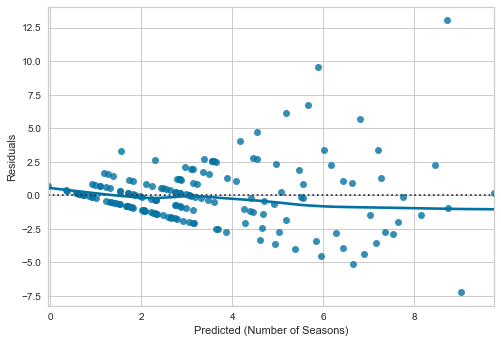

In [186]:
sns.residplot(x=ridge_model.predict(X_test), y=y_test, lowess=True)
#plt.title('Residuals')
plt.xlabel('Predicted (Number of Seasons)')
plt.ylabel('Residuals');

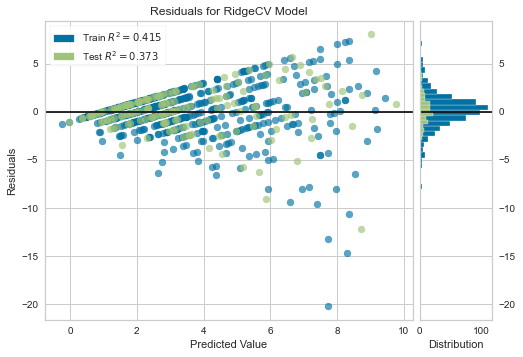

In [196]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge_model, train_alpha = .65, test_alpha = .65)

visualizer.fit(X_80, y_80)
visualizer.score(X_test, y_test)
#visualizer.show()
visualizer.show(outpath="yellowbrickresiduals.png");

### Try log y

In [67]:
df['log_y'] = np.log(df['Num_of_Seasons'])

In [69]:
df.head(3)

,Title,Start_Year,End_Year,Genres,Num_of_Seasons,Num_of_Episodes,Num_Episodes_Per_Season,Season_1_Rating,Years_Ran,Action,...,Romance,Sci-fi,Sport,Thriller,War,MPAA_Rating,Runtime,Series_Type,Ordinal_MPAA,log_y
0,Chernobyl,2019,2019,"[Drama, History, Thriller]",1,5,5.00,9.6,1,0,...,0,0,0,1,0,TV-MA,5h 30min,TV Mini-Series (2019),6,0.000000
1,Game of Thrones,2011,2019,"[Action, Drama, Adventure]",8,73,9.12,9.1,8,1,...,0,0,0,0,0,TV-MA,57min,TV Series (2011–2019),6,2.079442
2,Black Mirror,2011,0,"[Drama, Sci-fi, Thriller]",5,22,4.40,8.1,9,0,...,0,1,0,1,0,TV-MA,1h,TV Series (2011– ),6,1.609438


In [72]:
y2 = df['log_y']

#Split the data 55 - 25 - 20 train/val/test

X2_80, X2_test, y2_80, y2_test = train_test_split(X, y2, test_size=0.2,random_state=42)


In [83]:
#find the mean and standard deviation of the training seet
std2 = StandardScaler()
std2.fit(X2_80.values)


#Scale the Predictors on both the train and test set based on the scale found above
X2_tr = std2.transform(X2_80.values)

In [84]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha

ridge_model2 = RidgeCV(cv=5)
ridge_model2.fit(X2_tr, y2_80)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [85]:
#these are the standardized coeffs when the model refit using the new alpha
list(zip(X2_80.columns, ridge_model2.coef_))

[('Start_Year', -0.3675620276878115),
 ('Num_Episodes_Per_Season', 0.18179619705323502),
 ('Season_1_Rating', 0.023213712314410113),
 ('Action', -0.013024860616593963),
 ('Adventure', -0.013022042565250875),
 ('Animation', -0.06523533051883262),
 ('Biography', -0.037613666325625045),
 ('Comedy', 0.05718538956088925),
 ('Crime', 0.07791957511877966),
 ('Documentary', -0.09558975232013693),
 ('Drama', -0.02051963970678389),
 ('Family', 0.010932654969987432),
 ('Fantasy', -0.009236810294176702),
 ('History', -0.0394608225767629),
 ('Horror', -0.008833093164859728),
 ('Music', -0.022749338425824505),
 ('Mystery', 0.003968806887941946),
 ('Other', 0.049490175854378045),
 ('Romance', -0.002879288525693655),
 ('Sci-fi', -0.008609768557285711),
 ('Sport', 0.00026107443329197167),
 ('Thriller', 0.03327757098549331),
 ('War', -0.008023515754484928),
 ('Ordinal_MPAA', -0.024857534959932537)]

In [86]:
# Make predictions on the val set using the new model
val_set_pred2 = ridge_model2.predict(X2_test)

In [87]:
mae(y2_test, val_set_pred2)

737.848667961416

In [90]:
rmse(y2_test, val_set_pred2)

544427.1132673272

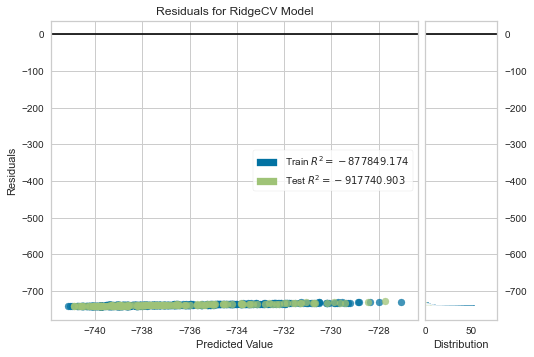

In [94]:

visualizer2 = ResidualsPlot(ridge_model2
                           )

visualizer2.fit(X2_80, y2_80)
visualizer2.score(X2_test, y2_test)
visualizer2.show();

bruh.. log(y) is wild. I'm not gonna use that shi

## Can't find a summary stats for ridgecv adjusted R^2 so i'm gonna code one

In [106]:
ridge_model.get_params()

{'alphas': array([ 0.1,  1. , 10. ]),
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': None,
 'store_cv_values': False}

In [107]:
def adjusted_r2(r2, n, k):
    '''
    Function to calculate adjusted R^2
    
    <Input> r2 (Type = float): R^2, 
            n (Type = int): number of data points in the data sample
            k (Type = int): number of independent variables in th model
            
    <Returns> adjusted R^2 (Type = float)
            
    '''
    
    return (1 - ((1-r2)*(n-1)/(n-k-1)))

In [108]:
X.shape #tells us 849 data points, 24 features

(849, 24)

In [109]:
adjusted_r2(r2_score(y_test, val_set_pred), 849, 24)

0.3549787373619244

In [124]:
type(ridge_model2.coef_)

numpy.ndarray

In [166]:
ridge_model2.coef_.shape

(24,)

### Predict the lifespan of my favorite show

In [205]:
Harley_quinn = np.array([2019,13, 8.3, 1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 6])

In [206]:
Harley_quinn.shape

(24,)

In [210]:
print(ridge_model.predict(Harley_quinn.reshape(1,-1)))

[1.30282185]
